<a href="https://colab.research.google.com/github/BureddySaiPoojitha/Module2_Lab3_AIML_-/blob/main/MODULE2_LAB3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Module 2 :Appreciating ,Interpreting and Visualizing Data**


# Lab 3 : Manifold Learning Methods

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold, datasets

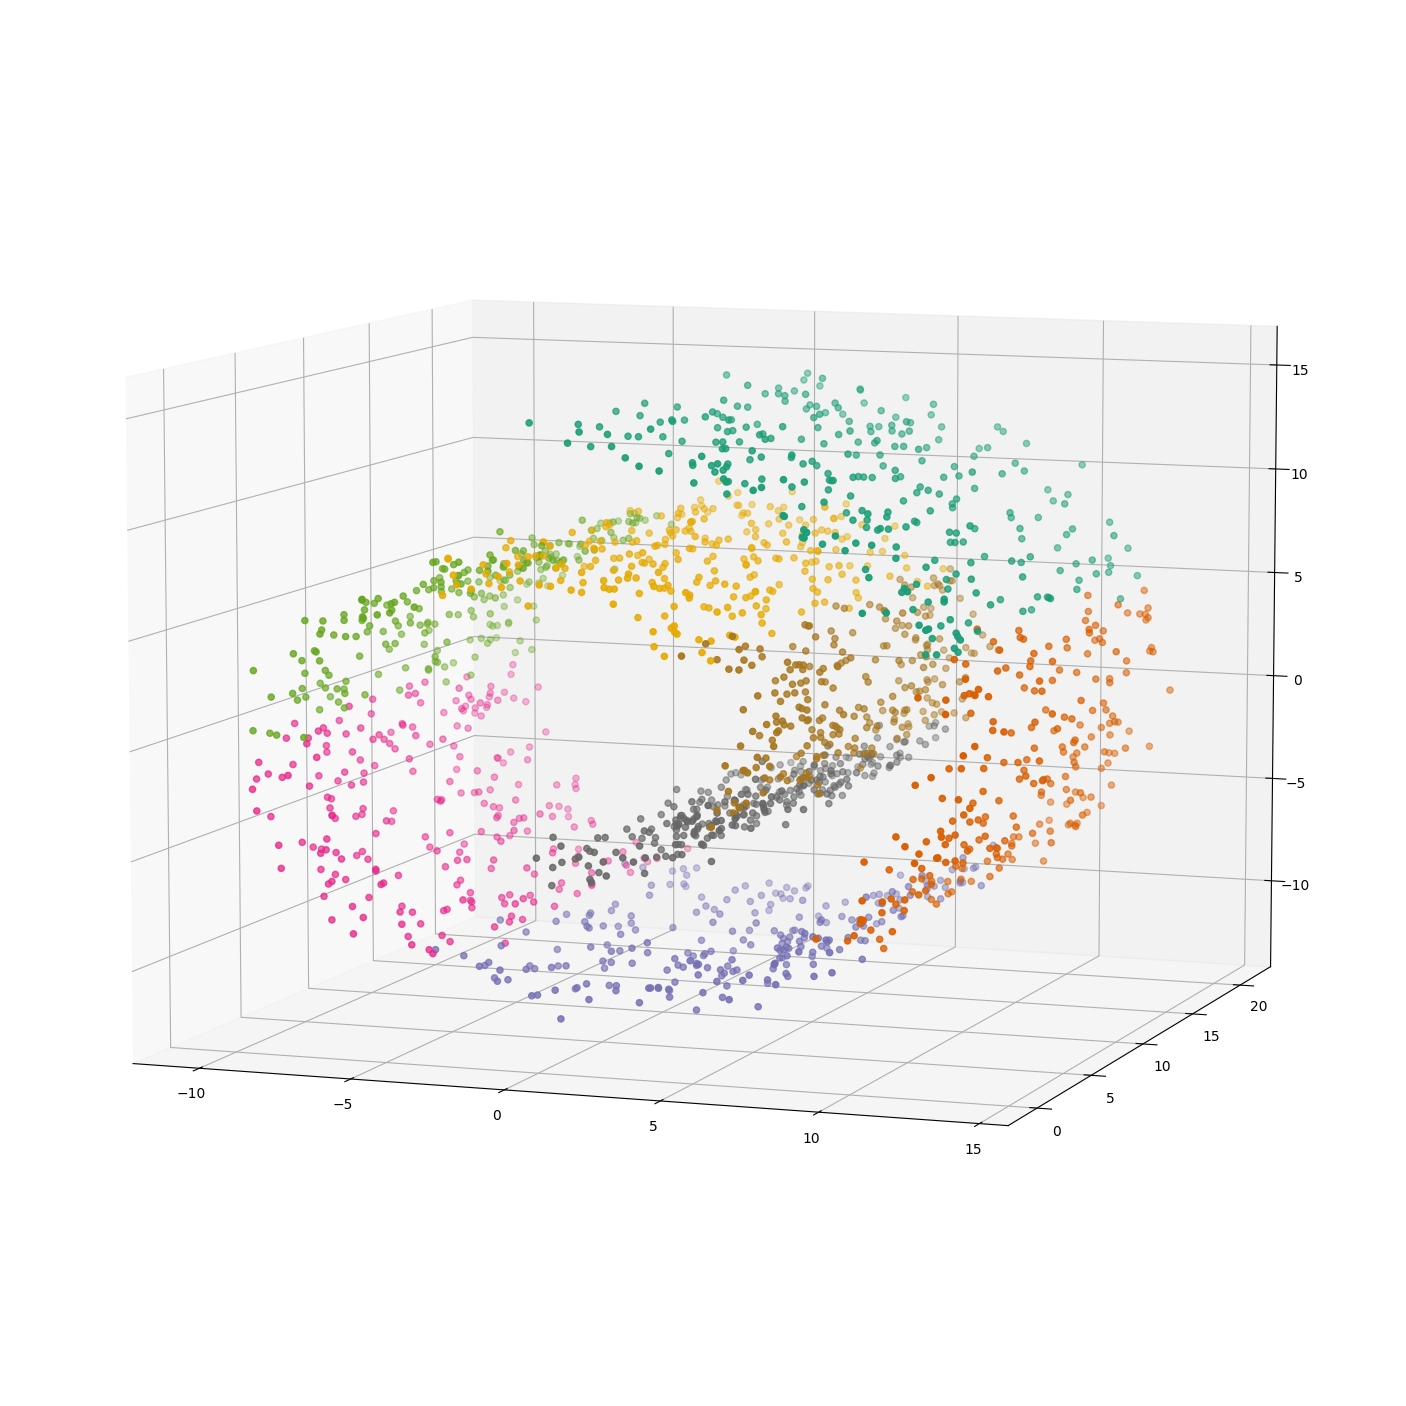

In [ ]:
n_points=2000
X,color=datasets.make_swiss_roll(n_points,noise=0.5,random_state=0)
fig = plt.figure(figsize=(25, 18))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Dark2_r)
ax.view_init(8, -70)

## Step1 a: First lets compute the distance matrix

In [ ]:
def dist(a,b):
  return np.sqrt(sum((a-b)**2))
distances=np.array([[dist(a,b) for a in X] for b in X])
print(distances.shape)

(2000, 2000)


## Step 1b: Lets us keep only k nearest neighbors for each point in the distance matrix.

In [ ]:
n_neighbors=10
neighbors=np.zeros(distances.shape)
sort_distances=np.argsort(distances,axis=1)[:,1:n_neighbors+1]
for k,i in enumerate(sort_distances):
  neighbors[k,i]=distances[k,i]
neighbors.shape

(2000, 2000)

Step 2:Weight graph edges by inter-point distances and then apply Dijkstra's all pairs shortest-paths algorithm

In [ ]:
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path
graph=shortest_path(neighbors,directed=False)


Step 3: Take the top d eigenvectors of the Gram matrix

In [ ]:
gram=(graph**3)

In [ ]:
n_samples=gram.shape[0]
meanrows=np.sum(gram,axis=0)/n_samples
meancols=(np.sum(gram,axis=1)/n_samples)[:,np.newaxis]
meanall=meanrows.sum()/n_samples
gram-=meanrows
gram-=meancols
gram+=meanall

In [ ]:
eig_val_cov, eig_vec_cov = np.linalg.eig(gram)
eig_pairs = [(np.abs(eig_val_cov[i]), eig_vec_cov[:, i]) for i in range(len(eig_val_cov))]
eig_pairs.sort(key=lambda x: x[0], reverse=True)
eig_pa_chebyshevirs = np.array(eig_pairs, dtype=object)

n_components = 5

reduced_matrix = np.zeros((n_components, gram.shape[1]))
for i in range(n_components):
  reduced_matrix[i,:] = eig_pa_chebyshevirs[i,1]
reduced_matrix = reduced_matrix.T

Plotting the resultant reduced_matrix

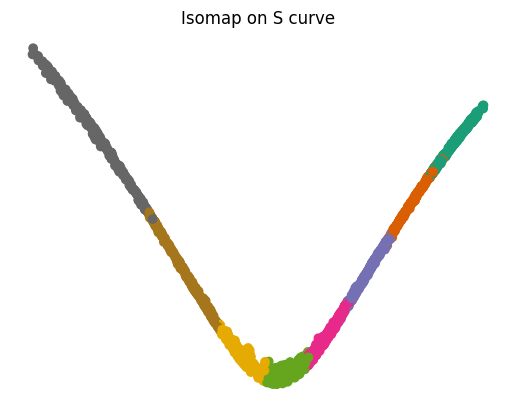

In [ ]:
ax = fig.add_subplot(222)
plt.scatter(reduced_matrix[:, 0], reduced_matrix[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('off')
plt.show()

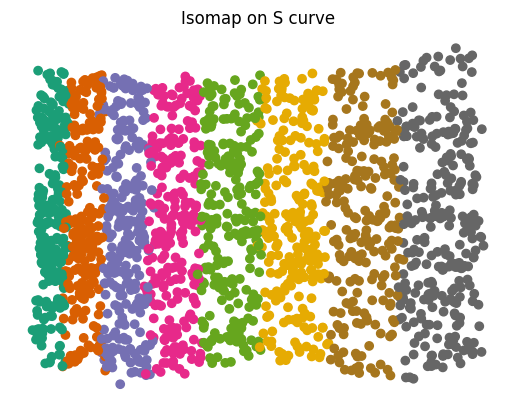

In [ ]:
from sklearn.manifold import Isomap
Y = Isomap(n_neighbors=23, n_components=2).fit_transform(X)

ax = fig.add_subplot(111)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Dark2)
plt.title("Isomap on S curve")
plt.axis('off')
plt.show()

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=100)
faces.data.shape

(530, 2914)

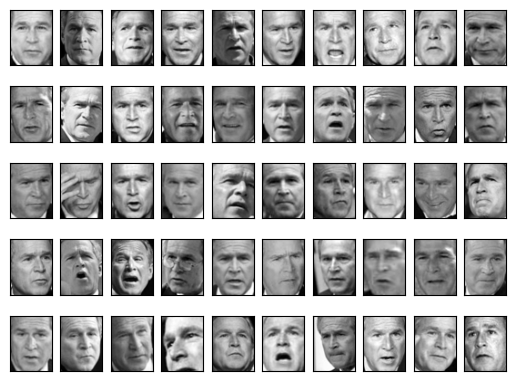

In [ ]:
fig, ax = plt.subplots(5,10, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

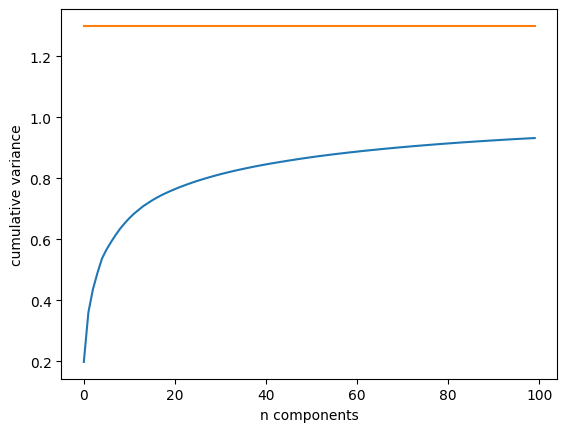

In [ ]:
from sklearn.decomposition import PCA as RandomizedPCA
model = RandomizedPCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')
plt.plot(range(100), 1.3*np.ones(100))

In [ ]:
model = Isomap(n_components=7, n_neighbors = 9)
proj = model.fit_transform(faces.data)
proj.shape

(530, 7)

In [ ]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None, thumb_frac=0.09, cmap='gray'):
    ax = ax or plt.gca()
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')

    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            # Change axis to 1 to sum along the correct dimension
            dist = np.sum((proj[i] - shown_images) ** 2, axis=1)
            if np.min(dist) < min_dist_2:
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Text(0, 0.5, 'Image Darkness')

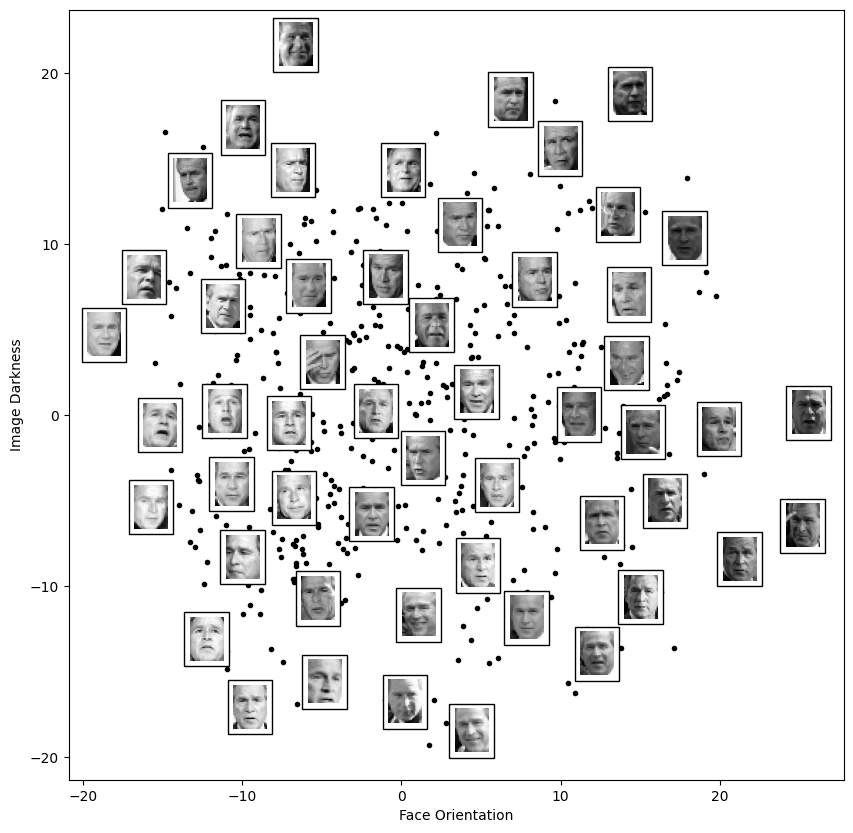

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2, n_neighbors = 5),
                images=faces.images[:, ::2, ::2])
plt.xlabel("Face Orientation")
plt.ylabel("Image Darkness")

# Exercises

# 1.  How do you think would the number of neighbors effect the Isomap algorithm? What happens when the number of neighbors considered is very large? What happens when it is very low?




The number of neighbors in the Isomap algorithm significantly impacts how well it maps the manifold structure of the data:

**Low Neighbors:** Poor global structure, risk of disconnected graph, and high sensitivity to noise.  
**High Neighbors:** Loss of local detail, flattened geometry, and higher computational cost.  
**Optimal Neighbors:** Ensure connectivity without over-densifying the graph; balance global and local structure.  

# 2.  When is the ISOMAP algorithm superior to PCA?

When working with non-linear manifolds, Isomap performs better than PCA because it maintains geodesic distances, captures global linkages, and manages curved or folded data structures with ease.

# 3.  Search up another manifold learning methods other than ISOMAP? If there are any, whats the key difference ?

Other learning strategies outside ISOMAP include:  

Although it may damage global structure, **LLO (Locally Linear Embedding):** maintains local topology and concentrates on local links.  
2. **t-SNE:** Focuses less on global structure and preserves local similarities, making it excellent for visualizing clusters.  
3. **Laplacian Eigenmaps:** A spectral method for connectivity and cluster preservation.  
Using kernels, PCA is extended for non-linear data in the fourth step.  
5. **SOM (Self-Organizing Maps):** Inspired by neural networks, this method quickly converts high-dimensional data into grids with little theoretical backing.  

Their emphasis on local vs global structures and computational complexity represent important distinctions.

# 4.  Suggest ways to deal with missing data in manifold learning.

To handle missing data in manifold learning, here are expanded strategies:

1. **Imputation:**  
    Use **mean/median imputation** for simplicity, or **k-NN imputation** to estimate based on similar points.  
    Regression-based imputation uses known features to predict missing ones, improving accuracy for structured data.

2. **Matrix Factorization:**  
    Techniques like **SVD** or **NMF** reconstruct missing entries by assuming low-rank data structures, making them ideal for high-dimensional data.

3. **Iterative Algorithms:**  
    Initialize missing values randomly or with estimates, run the manifold learning algorithm, update missing values using learned embeddings, and repeat until convergence.

4. **Graph-Based Interpolation:**  
    In ISOMAP or LLE, use local neighborhoods or shortest paths in the graph to approximate missing values.  

5. **Denoising Autoencoders:**  
    Train autoencoders to reconstruct corrupted data, filling in gaps while preserving manifold structure.

6. **Pairwise Distance Substitution:**  
    For ISOMAP or similar methods, replace unavailable distances with approximate values computed from nearby points.

7. **Expectation-Maximization (EM):**  
    Treat missing values as latent variables, updating their estimates iteratively to maximize the likelihood of the observed data.

8. **Data Selection or Weighting:**  
    Exclude points with excessive missing values or reduce their influence using weighted distances or embeddings.

These methods work best when matched to the specific data's missingness pattern and overall structure, balancing accuracy with computational efficiency.